# Proton Spin Up

In [2]:
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from scipy import optimize
from scipy.optimize import curve_fit

## Polarization vs Time

<Axes: title={'center': 'Polarization Over Time'}, xlabel='Datetime', ylabel='Polarization'>

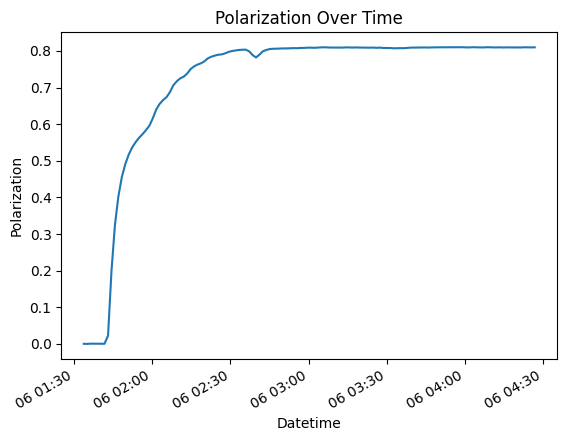

In [3]:

with open("2022-11-05_23-29-51__2022-11-06_11-20-39.txt","r") as eventfile:
    df = pd.read_json(eventfile, lines=True)
df['stop_time'] = pd.to_datetime(df['stop_time'])
df.set_index('stop_time', inplace=True)

df['pol'].plot(title='Polarization Over Time',
                      xlabel='Datetime',
                      ylabel='Polarization')


## Interactive Plot, Drag Slider to Select Result Curve

In [11]:
def plot_pol_array(index):
    plt.figure(figsize=(10, 6))
    signal_array = df.iloc[index]['rescurve']  # Get array from selected row
    plt.plot(signal_array, linewidth=2)
    plt.title(f"Result Signal {index} (Polarization: {df.iloc[index]['pol']:.2f})")
    plt.grid(True, alpha=0.3)
    plt.show()


# Create interactive widget
interact(plot_pol_array,
         index=IntSlider(min=0, max=len(df)-1, step=1, value=9,
                         description='Row Index:'))


interactive(children=(IntSlider(value=9, description='Row Index:', max=131), Output()), _dom_classes=('widget-…

<function __main__.plot_pol_array(index)>

In [ ]:
# Define Gaussian(s)
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

def three_gaussians(x, *params):
    return sum(gaussian(x, *params[i:i+3]) for i in range(0, 9, 3))

# Store fit results
fit_results = []

# Fit and plot individual curve
def plot_pol_array_with_fit(index):
    plt.figure(figsize=(10, 6))
    signal_array = df.iloc[index]['rescurve']
    x_data = np.arange(len(signal_array))

    mean_val = np.mean(signal_array)
    initial_guess = [
        mean_val / 3, len(signal_array) / 4, 100,
        mean_val / 3, len(signal_array) / 2, 100,
        mean_val / 3, 3 * len(signal_array) / 4, 100
    ]

    popt, _ = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess)

    # Append results
    fit_results.append({
        'index': index,
        'time': df.index[index],
        'pol': df.iloc[index]['pol'],
        'params': popt
    })

    # Plot original and fit
    plt.plot(x_data, signal_array, label='Original Signal', linewidth=2)
    plt.plot(x_data, three_gaussians(x_data, *popt), '--', color='red', label='Total Fit')

    # Plot Gaussians
    colors = ['blue', 'green', 'purple']
    for i in range(3):
        amp, cen, wid = popt[i*3:i*3+3]
        label = f'Gaussian{i+1}: Amplitude={amp:.1f}, Center={cen:.1f}, Width={wid:.1f}'
        g = gaussian(x_data, amp, cen, wid)
        plt.plot(x_data, g, linestyle=':', color=colors[i], label=label)

    plt.title(f"Signal {index} | Polarization: {df.iloc[index]['pol']:.2f}")
    plt.xlabel("Index")
    plt.ylabel("Signal")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# Create slider
interact(plot_pol_array_with_fit,
         index=IntSlider(min=0, max=len(df)-1, step=1, value=9, description='Row Index:'))






interactive(children=(IntSlider(value=9, description='Row Index:', max=131), Output()), _dom_classes=('widget-…

<function __main__.plot_pol_array_with_fit(index)>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

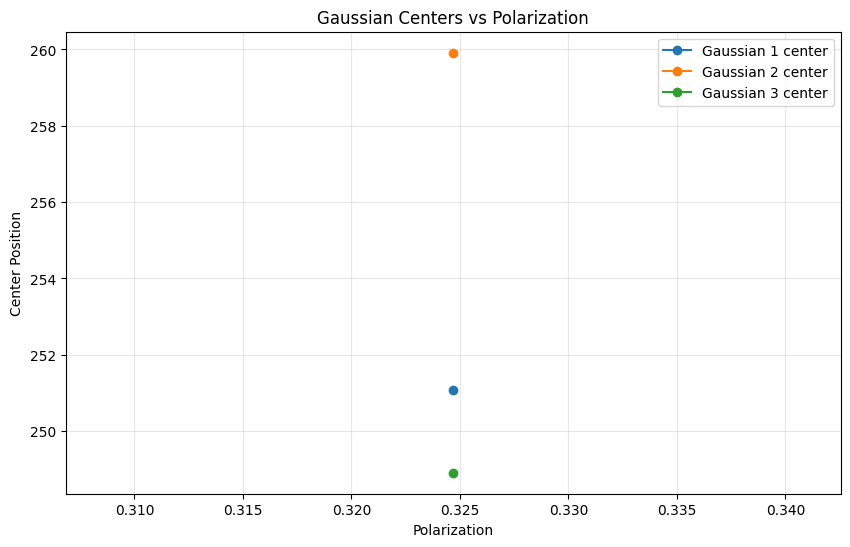

In [20]:
# Convert fit results to DataFrame
fit_df = pd.DataFrame(fit_results)

# How Gaussian center changes with polarization
plt.figure(figsize=(10,6))
for i in range(3):
    centers = fit_df['params'].apply(lambda p: p[i*3+1])
    plt.plot(fit_df['pol'], centers, 'o-', label = f'Gaussian {i+1} center')

plt.xlabel('Polarization')
plt.ylabel('Center Position')
plt.title('Gaussian Centers vs Polarization')
plt.grid(True, alpha = 0.3)
plt.legend()
plt.show()